In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, permutation_test_score
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

## Importing and formating data

In [43]:
# import data from file
file_path = 'winequality/winequality-red.csv'
data = np.genfromtxt(file_path, delimiter=';', skip_header=1)
print(data)

[[ 7.4    0.7    0.    ...  0.56   9.4    5.   ]
 [ 7.8    0.88   0.    ...  0.68   9.8    5.   ]
 [ 7.8    0.76   0.04  ...  0.65   9.8    5.   ]
 ...
 [ 6.3    0.51   0.13  ...  0.75  11.     6.   ]
 [ 5.9    0.645  0.12  ...  0.71  10.2    5.   ]
 [ 6.     0.31   0.47  ...  0.66  11.     6.   ]]


In [44]:
# normalize parameters to [0,1]
for i in range(len(data[0,:-1])):
    mi = min(data[:,i])
    ma = max(data[:,i])
    data[:,i] -= mi
    data[:,i] /= (ma - mi)
# Shuffle the rows just in case we want to split data in parts and they're sorted
np.random.shuffle(data)
print(data)

[[0.53097345 0.48630137 0.37       ... 0.11377246 0.23076923 5.        ]
 [0.42477876 0.3869863  0.26       ... 0.13173653 0.15384615 5.        ]
 [0.61946903 0.19863014 0.54       ... 0.25748503 0.23076923 7.        ]
 ...
 [0.24778761 0.31506849 0.         ... 0.1497006  0.44615385 6.        ]
 [0.26548673 0.21232877 0.4        ... 0.1257485  0.58461538 6.        ]
 [0.20353982 0.44178082 0.02       ... 0.26946108 0.23076923 5.        ]]


In [45]:
X = data[:, :-1]
y = data[:, -1].astype(int)

## Finding optimal kernel hyperparameters

In [46]:
C_opt = 1.3
gamma_opt = 10

In [6]:
'''
#parameters = {'C':[0.01, 0.1, 1, 10, 100], 'gamma':[0.01, 0.1, 1, 10, 100]}
#parameters = {'C':[1, 1.2, 1.3, 1.4, 1.6], 'gamma':[8, 9, 10, 11, 13]}
parameters = {'C':[2.1, 2.3, 2.4, 2.5, 2.7], 'gamma':[65, 68, 70, 72, 75]}

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=123)
scores = np.zeros((len(parameters['C']), len(parameters['gamma'])))

for iC, C in enumerate(parameters['C']):
    for ig, gamma in enumerate(parameters['gamma']):
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X_train, y_train)
        pred = model.predict(X_test)
        for i in range(len(y_test)):
            scores[iC, ig] += (pred[i] - y_test[i]) ** 2

opt_indices = np.unravel_index(np.argmin(scores), scores.shape)
C_opt = parameters['C'][opt_indices[0]]           # white: 2.4  red: 1.3
gamma_opt = parameters['gamma'][opt_indices[1]]   # white: 72   red: 10

print(scores)
print('best score: ', scores[opt_indices])
print("C_opt     = ", C_opt)
print("gamma_opt = ", gamma_opt)
'''

[[139. 140. 135. 130. 131.]
 [136. 136. 132. 130. 132.]
 [136. 136. 133. 131. 131.]
 [136. 137. 135. 131. 133.]
 [137. 137. 135. 131. 128.]]
best score:  128.0
C_opt     =  2.7
gamma_opt =  75


## Training the model

In [47]:
samplesize = len(y)
divisions = 5
divsize = samplesize//divisions
models = []
preds = []
accuracies = np.zeros(divisions)

for i in range(divisions):
    X_cvtrn = np.concatenate((X[:i*divsize, :], X[(i+1)*divsize:, :]))
    X_cvtst = X[i*divsize:(i+1)*divsize, :]
    y_cvtrn = np.concatenate((y[:i*divsize], y[(i+1)*divsize:]))
    y_cvtst = y[i*divsize:(i+1)*divsize]
    models.append(svm.SVC(kernel='rbf', gamma=gamma_opt, C=C_opt).fit(X_cvtrn, y_cvtrn))
    preds.append(models[i].predict(X_cvtst))
    accuracies[i] = accuracy_score(y_cvtst, preds[i])
    print(accuracies[i]*100)

accuracy = np.average(accuracies)
accuracy_stdev = np.std(accuracies)
print('\nAccuracy: ', "%.2f" % accuracy, '   stdev: ', "%.2f" % accuracy_stdev)


62.695924764890286
60.18808777429467
65.20376175548589
65.20376175548589
63.322884012539184

Accuracy:  0.63    stdev:  0.02


### Confusion matrix

In [14]:
conf_mtrx = np.zeros((10, 10))
for j in range(divisions):
    y_t = y[j*divsize:(j+1)*divsize]
    for i in range(len(y_t)):
        conf_mtrx[preds[j][i]-1, y_t[i]-1] += 1

acc_with_tolerance = (np.sum(np.diag(conf_mtrx, k=1)) + np.sum(np.diag(conf_mtrx)) + np.sum(np.diag(conf_mtrx, k=-1))) / np.sum(conf_mtrx)
print('\nAccuracy (accepting off-by-one estimates): ', "%.3f" % acc_with_tolerance)


Accuracy (accepting off-by-one estimates):  0.950


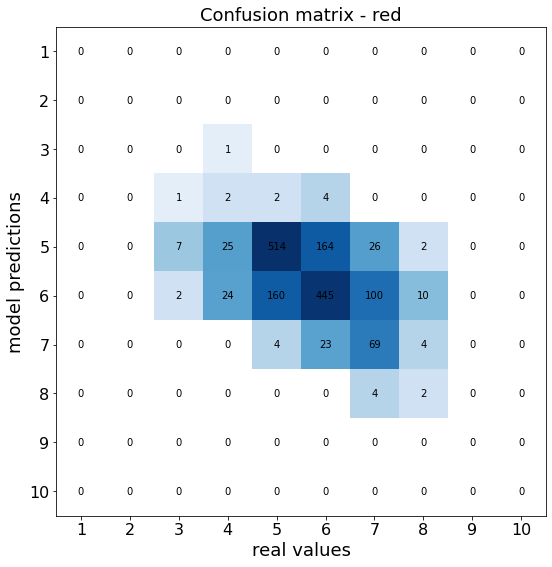

In [12]:
plt.figure(figsize=(9, 9))
cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip([0, 1/conf_mtrx.max(), 1], [(1, 1, 1), (0.78, 0.86, 0.93), (0.03, 0.19, 0.42)])))
plt.imshow(conf_mtrx, interpolation='nearest', cmap='Blues', norm=mcolors.LogNorm(vmin=0.5, vmax=conf_mtrx.max()))

for i in range(conf_mtrx.shape[0]):
    for j in range(conf_mtrx.shape[1]):
        plt.text(j, i, "{:.0f}".format(conf_mtrx[i, j]), ha='center', va='center', color='black')

#plt.colorbar()
plt.xticks(np.arange(0, conf_mtrx.shape[1], 1), np.arange(1, conf_mtrx.shape[1]+1, 1), fontsize=16)
plt.yticks(np.arange(0, conf_mtrx.shape[0], 1), np.arange(1, conf_mtrx.shape[0]+1, 1), fontsize=16)
plt.xlabel('real values', fontsize=18)
plt.ylabel('model predictions', fontsize=18)
plt.title('Confusion matrix - red', fontsize=18)
plt.show()

### Sensitivity analysis

In [53]:
importances = np.zeros((divisions, len(X[0,:])))

for i in range(divisions):
    for j in range(len(X[0,:])):
        shuffled = X[i*divsize:(i+1)*divsize, :].copy()
        column = shuffled[:, j]
        np.random.shuffle(column)
        shuffled[:, j] = column

        pred_shf = models[i].predict(shuffled)
        acc_shf = accuracy_score(y[i*divsize:(i+1)*divsize], pred_shf)
        importances[i,j] = accuracy - acc_shf

    importances[i,:] *= 100/np.sum(importances[i,:])

imp_avg = [np.average(importances[:,j]) for j in range(len(X[0,:]))]
imp_std = [np.std(importances[:,j]) for j in range(len(X[0,:]))]
print(imp_avg)
print(imp_std)

[6.033015628081826, 15.281088816327912, 6.24409772838015, 4.049179125808346, 0.4714079234458569, 3.7938431222124462, 8.165551348949974, 11.091505557043456, 0.3937218820186704, 12.856871898860959, 31.61971696887041]
[3.3846905776823433, 6.813441793427667, 3.426785152831491, 4.908140786619029, 4.83825620594413, 4.433617550391624, 3.888849040278963, 3.822534190711855, 5.269416577600444, 2.7812487075511267, 11.264697937490796]


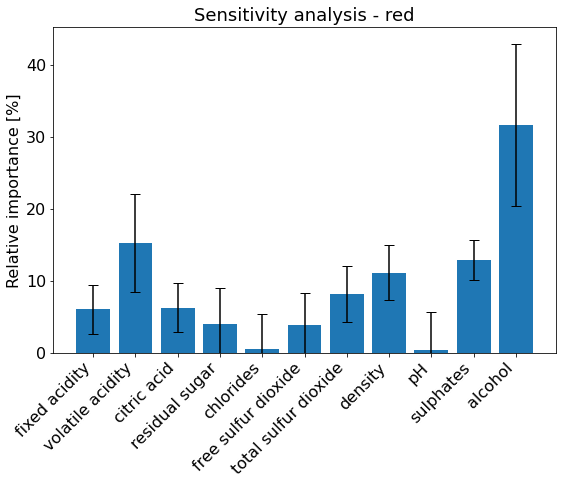

In [54]:
features = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
plt.figure(figsize=(9, 6))
plt.bar(features, imp_avg, yerr=imp_std, capsize=5)
plt.ylabel('Relative importance [%]', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(bottom=0)
plt.title('Sensitivity analysis - red', fontsize=18)
plt.show()

### Significance analysis

In [28]:
def get_permutation_scores(X, y, model, n_permutations=100):
    scores = np.zeros(n_permutations)
    predictions = model.predict(X)
    real_score = accuracy_score(y, predictions)
    pvalue = 0
    for i in range(n_permutations):
        y_permuted = np.random.permutation(y)
        scores[i] = accuracy_score(y_permuted, predictions)
        if scores[i] > real_score:
            pvalue += 1
    pvalue /= n_permutations
    return (scores, real_score, pvalue)

i_mod = 3
perm_scores, score, pvalue = get_permutation_scores(X[i_mod*divsize:(i_mod+1)*divsize, :], y[i_mod*divsize:(i_mod+1)*divsize], models[i_mod], 10000)
print(pvalue)

0.0


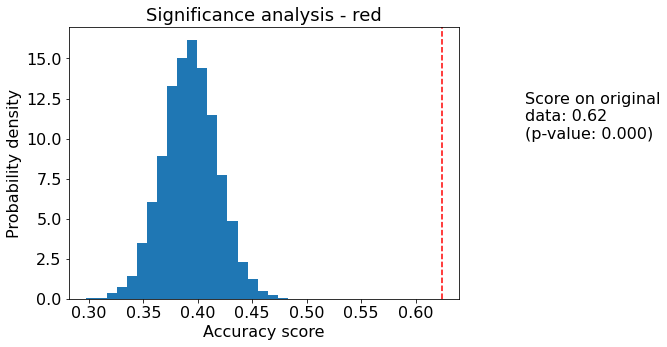

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.hist(perm_scores, bins=20, density=True)
ax.axvline(score, ls="--", color="r")
score_label = f"Score on original\ndata: {score:.2f}\n(p-value: {pvalue:.3f})"
ax.text(0.7, 10, score_label, fontsize=16)
ax.set_title("Significance analysis - red", fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Accuracy score", fontsize=16)
_ = ax.set_ylabel("Probability density", fontsize=16)

### Training with removed features

(0.0, 1.0)

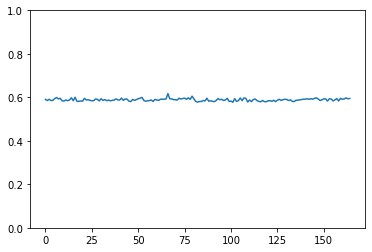

In [37]:
# Implementation of method 2

# Reloading data
def load_and_process(path):
    df = pd.read_csv(path, sep=';')
    data = df.values
    np.random.shuffle(data)
    X, y = data[:, :-1], data[:, -1].astype(int)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

def combinations_without_replacement(n, m):
    """
    n: number of elements
    m: number of elements to choose
    """
    comb = list(combinations(range(n), m))
    return np.array(comb)

path_red = 'winequality/winequality-red.csv'
X, y = load_and_process(path_red)
n_samples, n_features = X.shape

def get_accuracy(model, remove_features, n_splits=10):
    X_cleaned = np.delete(X, remove_features, axis=1)
    cv_scores = cross_val_score(model, X_cleaned, y, cv=n_splits, scoring='accuracy')
    cv_score_mean = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    return cv_score_mean, cv_score_std

def get_importances_remove(model, n_splits=10, depth=3):
    combs = combinations_without_replacement(n_features, depth)
    n_combs = combs.shape[0]
    importances = np.zeros(n_combs)
    for i, comb in enumerate(combs):
        to_remove = np.array(comb)
        importances[i] = get_accuracy(model, to_remove, n_splits=n_splits)[0]
    return combs, importances

#DT = DecisionTreeClassifier(random_state=42)
#RF = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
#BDT = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)
SVM = svm.SVC(kernel='rbf', gamma=gamma_opt, C=C_opt)

feats, importances = get_importances_remove(SVM, n_splits=5)
n = len(importances)

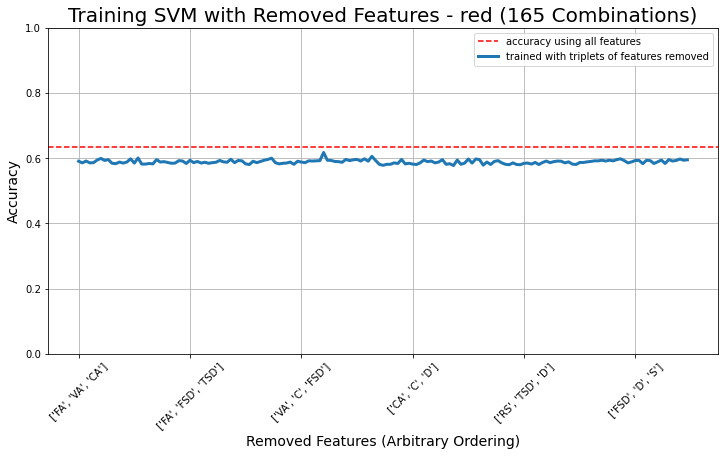

In [52]:
fontsize_label = 14
fontsize_ticks = 12
fontsize_title = 20

plt.figure(figsize=(12, 6))
plt.axhline(y=accuracy, color='r', linestyle='--', label="accuracy using all features")
plt.plot(range(n), importances, linewidth=3, label='trained with triplets of features removed')
plt.grid()
plt.ylim(0, 1)
plt.title(f'Training SVM with Removed Features - red ({n} Combinations)', fontsize=fontsize_title)
plt.xlabel('Removed Features (Arbitrary Ordering)', fontsize=fontsize_label)
plt.ylabel('Accuracy', fontsize=fontsize_label)
plt.legend()

n = len(feats)

labels_new = [label.split() for label in features]
initials = []
for label in labels_new:
    initials.append(''.join([word[0] for word in label]).upper())

tick_combs = [feats[i] for i in range(0, n, 30)]
tick_labels = [[initials[j] for j in comb] for comb in tick_combs]

plt.xticks(range(0, n, 30), tick_labels, rotation=45)
plt.savefig('./preselection.png', dpi=300, bbox_inches='tight')